# Set up and import dataset

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Set path to local data directory
folder_path = "/Users/dais/Downloads/Optiver_additional data"

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Display dataset dimensions and column names
print("Feature DF:", feature_df.shape)
print("Target DF:", target_df.shape)
print("\nFeature columns:", feature_df.columns.tolist())
print("\nTarget columns:", target_df.columns.tolist())

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Preview top and bottom of the stacked DataFrame
print("\nConcat DF (head):")
display(combined_df.head())

print("\nConcat DF (tail):")
display(combined_df.tail())


Feature DF: (17646119, 11)
Target DF: (17911332, 11)

Feature columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Target columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Concat DF (head):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
1,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
2,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
3,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
4,8382,6,1802.0,740.06,740.36,740.0,740.39,100,30,399,4



Concat DF (tail):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
35557446,104919,1199,3595.0,362.73,362.74,362.72,362.75,200,1190,1200,1600
35557447,104919,1199,3596.0,362.68,362.70,362.67,362.71,800,200,1600,1400
35557448,104919,1199,3597.0,362.69,362.70,362.68,362.71,200,900,1400,1400
35557449,104919,1199,3598.0,362.72,362.73,362.71,362.74,200,1000,900,500
35557450,104919,1199,3599.0,362.80,362.81,362.79,362.82,200,300,600,300


# Feature Engineering

In [2]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

# Preview result
feature_engineered_df.head()


,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation
0,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,NaN
1,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,0.000000
2,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
3,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016
4,8382,6,1802.0,740.290769,0.000405,0.538462,3.333333,0.000033


In [3]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df.head()


,date,time,time_id
0,2021-01-05,11:00:00,12
1,2021-01-05,12:00:00,13
2,2021-01-05,13:00:00,14
3,2021-01-05,14:00:00,15
4,2021-01-05,15:00:00,16


# Combine date and time into a full datetime column


In [4]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
time_ref_df.head()


,date,time,time_id,datetime
0,2021-01-05,11:00:00,12,2021-01-05 11:00:00
1,2021-01-05,12:00:00,13,2021-01-05 12:00:00
2,2021-01-05,13:00:00,14,2021-01-05 13:00:00
3,2021-01-05,14:00:00,15,2021-01-05 14:00:00
4,2021-01-05,15:00:00,16,2021-01-05 15:00:00


# Time ID to Real Time Mapping
NaT (Not a Time) means the merge didn’t find a matching time_id in time_ref_df
For example, time_id 6

In [5]:
# Re-do the merge and keep only the new datetime column
feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.head()
feature_engineered_df.tail()


,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,datetime
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,2021-10-07 16:00:00
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,2021-10-07 16:00:00
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,2021-10-07 16:00:00
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,2021-10-07 16:00:00
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,2021-10-07 16:00:00


# Train/Test Split 
## Chronological time_id-based split (80/20)

In [6]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)


TimeID Split:
Train shape: (28513833, 9)
Test shape: (7043618, 9)


## Date-based split (e.g., train on one day, test on next)

In [8]:
# First, extract just the date
feature_engineered_df["date_only"] = feature_engineered_df["datetime"].dt.date

# Check available dates
print("Available Dates:", feature_engineered_df["date_only"].unique())

# Choose any pair of consecutive dates (example below)
train_day = pd.to_datetime("2021-09-30").date()
test_day = pd.to_datetime("2021-10-01").date()

train_df_date = feature_engineered_df[feature_engineered_df["date_only"] == train_day]
test_df_date = feature_engineered_df[feature_engineered_df["date_only"] == test_day]

print("Date-based Split:")
print("Train shape:", train_df_date.shape)
print("Test shape:", test_df_date.shape)


Available Dates: [NaT datetime.date(2021, 1, 5) datetime.date(2021, 1, 6)
 datetime.date(2021, 1, 7) datetime.date(2021, 1, 8)
 datetime.date(2021, 1, 11) datetime.date(2021, 1, 12)
 datetime.date(2021, 1, 13) datetime.date(2021, 1, 14)
 datetime.date(2021, 1, 15) datetime.date(2021, 1, 19)
 datetime.date(2021, 1, 20) datetime.date(2021, 1, 21)
 datetime.date(2021, 1, 22) datetime.date(2021, 1, 25)
 datetime.date(2021, 1, 26) datetime.date(2021, 1, 27)
 datetime.date(2021, 1, 28) datetime.date(2021, 1, 29)
 datetime.date(2021, 2, 1) datetime.date(2021, 2, 2)
 datetime.date(2021, 2, 3) datetime.date(2021, 2, 4)
 datetime.date(2021, 2, 5) datetime.date(2021, 2, 8)
 datetime.date(2021, 2, 9) datetime.date(2021, 2, 10)
 datetime.date(2021, 2, 11) datetime.date(2021, 2, 12)
 datetime.date(2021, 2, 16) datetime.date(2021, 2, 17)
 datetime.date(2021, 2, 18) datetime.date(2021, 2, 19)
 datetime.date(2021, 2, 22) datetime.date(2021, 2, 23)
 datetime.date(2021, 2, 24) datetime.date(2021, 2, 25)


# Modeling with one stock 
Each stock has its own dynamics, so we usually train per stock

Each stock might behave diffrently to diffrent models and will required diffrent tuning 

In [10]:
# Choosing stock 
feature_engineered_df["stock_id"].value_counts()


stock_id
50200     4166788
104919    4166348
9323      4156560
22951     3943343
8382      3908378
22753     3730669
22675     3305761
22771     2960979
22729     2681810
48219     2536815
Name: count, dtype: int64

In [9]:
# Example with SPY XNAS
spy_df = feature_engineered_df[feature_engineered_df["stock_id"] == 50200].copy()
print(spy_df.tail())

# Check the datetime available
spy_df["date_only"] = spy_df["datetime"].dt.date




          stock_id  time_id  seconds_in_bucket         wap  spread_pct  \
31387533     50200     1199               30.0  439.034667    0.000023   
31387532     50200     1199               29.0  439.032188    0.000023   
31387531     50200     1199               28.0  439.047386    0.000023   
31387529     50200     1199               26.0  439.050939    0.000023   
31391102     50200     1199             3599.0  438.577500    0.000023   

          imbalance  depth_ratio  spread_variation            datetime  \
31387533  -0.066511     0.875274      7.655920e-10 2021-10-07 16:00:00   
31387532  -0.562363     0.280112      8.471857e-10 2021-10-07 16:00:00   
31387531   0.477124     2.825000      8.471857e-10 2021-10-07 16:00:00   
31387529  -0.812207     0.103627      6.114179e-10 2021-10-07 16:00:00   
31391102   0.500000     3.000000      7.212521e-06 2021-10-07 16:00:00   

           date_only  
31387533  2021-10-07  
31387532  2021-10-07  
31387531  2021-10-07  
31387529  2021-10-

<Axes: title={'center': 'SPY: Spread % Over Time'}, xlabel='datetime'>

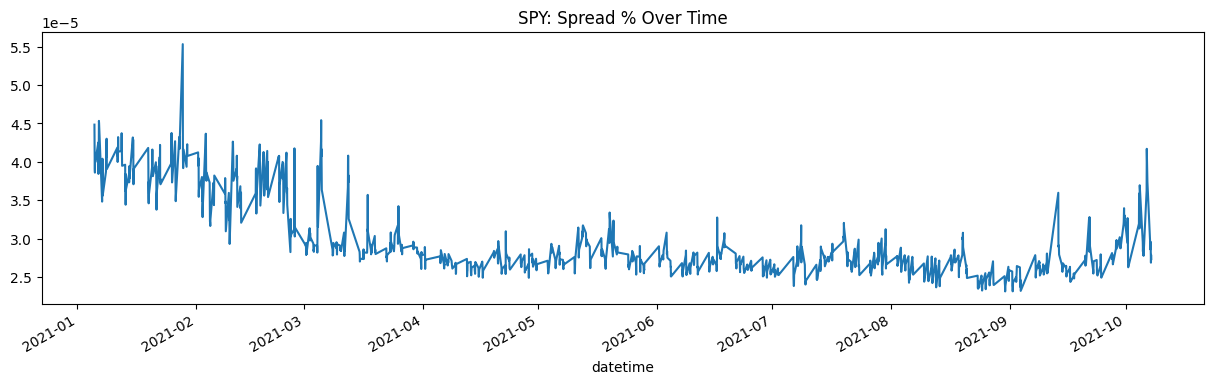

In [10]:
spy_df.groupby("datetime")["spread_pct"].mean().plot(
    figsize=(15,4), title="SPY: Spread % Over Time"
)

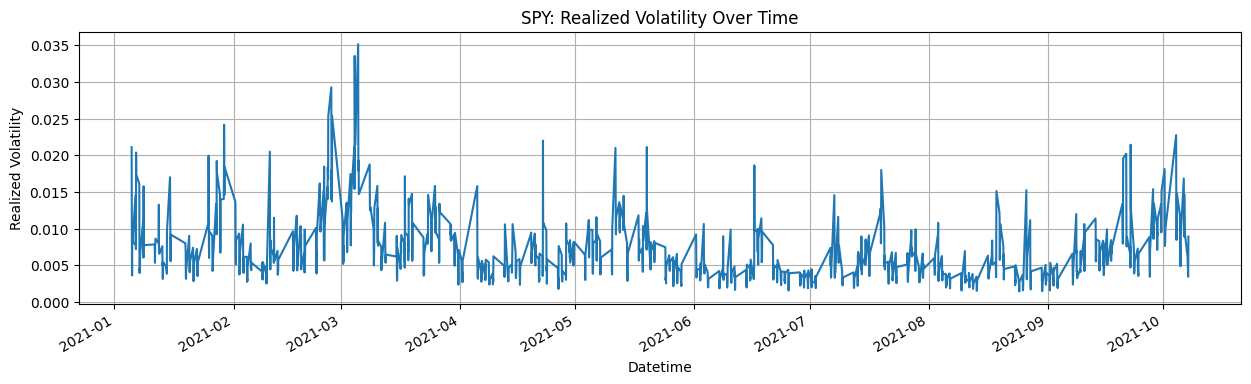

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#  Compute log returns (per time_id)
spy_df["log_return"] = spy_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))


# Compute realized volatility per time_id
rv_df = spy_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into spy_df
spy_df = pd.merge(spy_df, rv_df, on="time_id", how="left")

# Plot volatility over time
spy_df.groupby("datetime")["realized_volatility"].mean().plot(
    figsize=(15, 4), title="SPY: Realized Volatility Over Time"
)
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.grid(True)
plt.show()



# HAV RV as baseline model
## OLS

                             OLS Regression Results                            
Dep. Variable:     realized_volatility   R-squared:                       0.536
Model:                             OLS   Adj. R-squared:                  0.535
Method:                  Least Squares   F-statistic:                     440.6
Date:                 Fri, 18 Apr 2025   Prob (F-statistic):          3.31e-190
Time:                         18:04:34   Log-Likelihood:                 5072.2
No. Observations:                 1148   AIC:                        -1.014e+04
Df Residuals:                     1144   BIC:                        -1.012e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      5.64

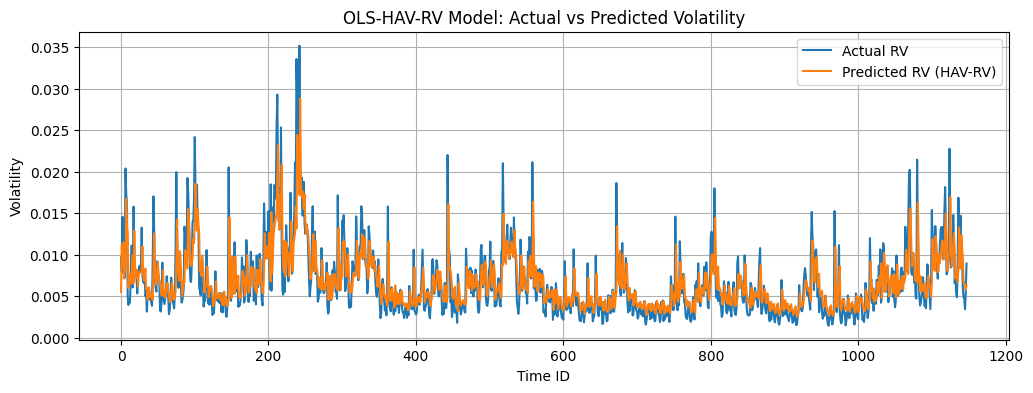

In [12]:
hav_df = rv_df.copy()

# Create lagged RV values (can change lag numbers if needed)
hav_df["rv_lag_1"] = hav_df["realized_volatility"].shift(1)
hav_df["rv_lag_5"] = hav_df["realized_volatility"].shift(5)
hav_df["rv_lag_10"] = hav_df["realized_volatility"].shift(10)

# Drop rows with missing lag values
hav_df = hav_df.dropna().reset_index(drop=True)

hav_df.head()
import statsmodels.api as sm

X = hav_df[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]
y = hav_df["realized_volatility"]

X = sm.add_constant(X)  # add intercept
hav_model = sm.OLS(y, X).fit()

print(hav_model.summary())  # View model stats
hav_df["predicted_rv"] = hav_model.predict(X)

plt.figure(figsize=(12, 4))
plt.plot(hav_df["realized_volatility"], label="Actual RV")
plt.plot(hav_df["predicted_rv"], label="Predicted RV (HAV-RV)")
plt.title("OLS-HAV-RV Model: Actual vs Predicted Volatility")
plt.xlabel("Time ID")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


## wls

                             WLS Regression Results                            
Dep. Variable:     realized_volatility   R-squared:                       0.558
Model:                             WLS   Adj. R-squared:                  0.557
Method:                  Least Squares   F-statistic:                     481.5
Date:                 Fri, 18 Apr 2025   Prob (F-statistic):          2.97e-202
Time:                         18:05:15   Log-Likelihood:                 5609.2
No. Observations:                 1148   AIC:                        -1.121e+04
Df Residuals:                     1144   BIC:                        -1.119e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007   9.77e-05      6.99

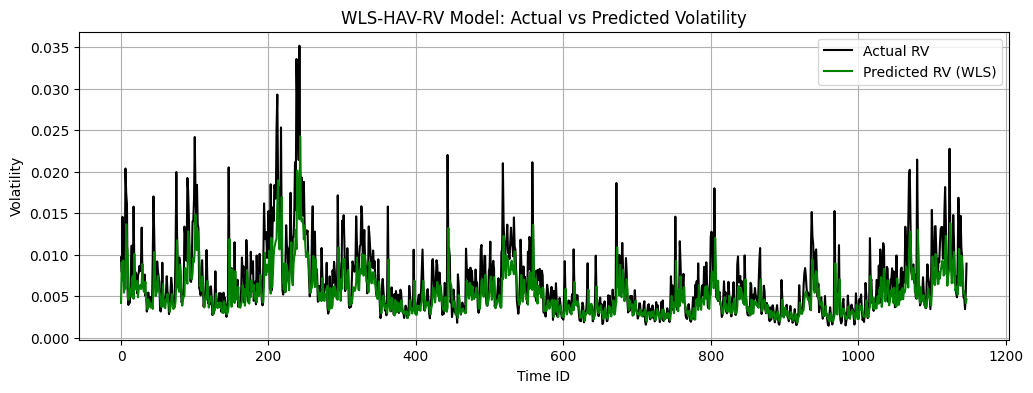

In [14]:
import statsmodels.api as sm

# Use the same X and y from before
X = hav_df[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]
X = sm.add_constant(X)
y = hav_df["realized_volatility"]

# Create weights: inverse of volatility (or squared), to reduce influence of high-vol rows
weights = 1 / (y ** 2)

# Fit WLS model
wls_model = sm.WLS(y, X, weights=weights).fit()

# Summary
print(wls_model.summary())


# Predict using WLS model
hav_df["predicted_rv_wls"] = wls_model.predict(X)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(hav_df["realized_volatility"], label="Actual RV", color="black")
plt.plot(hav_df["predicted_rv_wls"], label="Predicted RV (WLS)", color="green")

plt.title("WLS-HAV-RV Model: Actual vs Predicted Volatility")
plt.xlabel("Time ID")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


# Train/Test Split using chrnological time_id

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ✅ Step 1: Sort and compute lagged volatility safely
spy_df = spy_df.sort_values(by=["stock_id", "time_id"]).copy()

# Shifted realized volatility
spy_df["rv_lag_1"] = spy_df.groupby("stock_id")["realized_volatility"].shift(1)

# More efficient rolling lags using groupby apply
spy_df["rv_lag_5"] = (
    spy_df.groupby("stock_id")["rv_lag_1"]
    .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
)

spy_df["rv_lag_10"] = (
    spy_df.groupby("stock_id")["rv_lag_1"]
    .transform(lambda x: x.rolling(window=10, min_periods=1).mean())
)

# ✅ Step 2: Drop NaNs
model_df = spy_df.dropna(subset=["realized_volatility", "rv_lag_1", "rv_lag_5", "rv_lag_10"]).copy()

# ✅ Step 3: Chronological train/test split
unique_ids = sorted(model_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train = model_df[model_df["time_id"].isin(train_ids)]
test = model_df[model_df["time_id"].isin(test_ids)]

X_train = train[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]
y_train = train["realized_volatility"]
X_test = test[["rv_lag_1", "rv_lag_5", "rv_lag_10"]]
y_test = test["realized_volatility"]

# ✅ Step 4: Fit OLS
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

# ✅ Step 5: Predict + plot
X_test_const = sm.add_constant(X_test)
test = test.copy()
test["predicted_volatility"] = model.predict(X_test_const)

# Plot average per datetime
plot_df = test.groupby("datetime")[["realized_volatility", "predicted_volatility"]].mean()

plt.figure(figsize=(15, 4))
plt.plot(plot_df.index, plot_df["realized_volatility"], label="Actual Volatility")
plt.plot(plot_df.index, plot_df["predicted_volatility"], label="Predicted Volatility", linestyle="--")
plt.title("SPY: HAV-RV Predicted vs Actual (Optimized)")
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'spy_df' is not defined

In [ ]:
#!pip install statsmodels
#!pip install scikit-learn



Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 12.5 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
